In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
# global variables

look_back = 21
lead_time = 5
filename = '../../../data/Arctic_Monthy_Mean_1979_2021.csv'
gc_features = ['wind_10m', 'specific_humidity', 'LW_down', 'SW_down', 'rainfall', 'snowfall', 't2m', 'surface_pressure', 'sea_ice_extent']

In [3]:
# from google.colab import files
# import io

# uploaded = files.upload()
# df = pd.read_csv(io.BytesIO(uploaded[filename]))

# Reading the dataset
df = pd.read_csv(filename)
df.head()

,Date,wind_10m,specific_humidity,LW_down,SW_down,rainfall,snowfall,sst,t2m,surface_pressure,sea_ice_extent
0,1/1/1979,5.531398,0.811961,186.687054,3.127880,1.009872,0.892319,273.355237,250.388101,984.633032,15604191
1,2/1/1979,5.328020,0.688896,174.794571,18.541594,0.920831,0.781347,273.121885,247.071202,983.980418,16378929
2,3/1/1979,5.432511,0.916124,190.741933,67.690429,0.983327,0.855266,273.088099,252.954138,985.140468,16521089
3,4/1/1979,4.792836,1.272056,212.937925,156.223673,0.890723,0.705203,273.126062,259.557456,989.314698,15561238
4,5/1/1979,4.819028,2.239776,253.690478,230.950833,1.201308,0.688723,273.393551,269.375118,984.483658,14085613


In [4]:
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
df.set_index('Date', inplace=True)
df = df.astype(float)                 # cast df to float
df = df[gc_features]
df.tail(len(df))

,wind_10m,specific_humidity,LW_down,SW_down,rainfall,snowfall,t2m,surface_pressure,sea_ice_extent
Date,,,,,,,,,
1979-01-01,5.531398,0.811961,186.687054,3.127880,1.009872,0.892319,250.388101,984.633032,15604191.0
1979-02-01,5.328020,0.688896,174.794571,18.541594,0.920831,0.781347,247.071202,983.980418,16378929.0
1979-03-01,5.432511,0.916124,190.741933,67.690429,0.983327,0.855266,252.954138,985.140468,16521089.0
1979-04-01,4.792836,1.272056,212.937925,156.223673,0.890723,0.705203,259.557456,989.314698,15561238.0
1979-05-01,4.819028,2.239776,253.690478,230.950833,1.201308,0.688723,269.375118,984.483658,14085613.0
...,...,...,...,...,...,...,...,...,...
2021-04-01,5.383687,1.529497,225.171796,156.567743,1.159049,0.929777,263.146395,985.801841,13840000.0
2021-05-01,4.777020,2.451088,260.956781,229.604138,1.077705,0.575494,271.557464,985.606182,12660000.0
2021-06-01,4.771453,4.176458,294.931709,244.702852,1.585094,0.360146,278.360921,978.436682,10710000.0


In [5]:
def create_model_data (dataset, look_back, lead_time):
    dataX, dataY = [], []
    
    for i in range(len(dataset)-look_back-lead_time):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back + (lead_time-1)])
    return np.array(dataX), np.array(dataY)

In [6]:
target_index = df.columns.tolist().index('sea_ice_extent')

dataset = df.values.astype('float32')               # DataFrame converted to Numpy Array

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

X, y = create_model_data (dataset, look_back=look_back, lead_time=lead_time)
y = y[:,target_index]

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

<function matplotlib.pyplot.show(*args, **kw)>

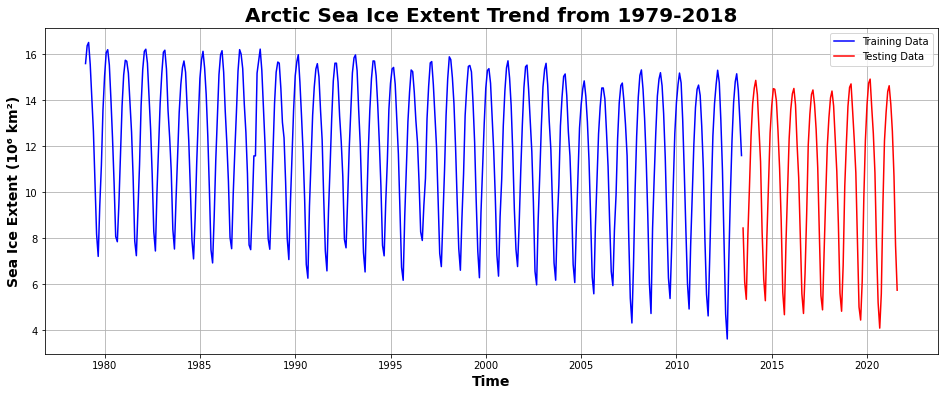

In [8]:
plt.figure(figsize = (16,6))
ax = plt.axes()
# ax.set_facecolor('#dcdcdc')

plt.title('Arctic Sea Ice Extent Trend from 1979-2018', fontsize = 20,fontweight = "bold")
plt.xlabel('Time' , fontsize = 14,fontweight = "bold")
plt.ylabel('Sea Ice Extent (10\u2076 km\u00b2)', fontsize = 14,fontweight = "bold")
plt.plot(df['sea_ice_extent'][:len(df)-len(y_test)]/10**6, 'blue', label='Training Data')
plt.plot(df['sea_ice_extent'][len(df)-len(y_test):]/10**6, 'red', label='Testing Data')
plt.legend()
plt.grid()
plt.show

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, LSTM, GRU, Dense

input_shape=(X.shape[1], X.shape[2])

model = Sequential()
model.add(GRU(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(256, return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(512, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(1024, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128))
model.add(Dropout(0.2))

model.add(Dense(64 ,  activation = 'relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 21, 64)            14400     
                                                                 
 dropout (Dropout)           (None, 21, 64)            0         
                                                                 
 gru_1 (GRU)                 (None, 21, 128)           74496     
                                                                 
 dropout_1 (Dropout)         (None, 21, 128)           0         
                                                                 
 gru_2 (GRU)                 (None, 21, 256)           296448    
                                                                 
 dropout_2 (Dropout)         (None, 21, 256)           0         
                                                                 
 gru_3 (GRU)                 (None, 21, 512)           1

In [10]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("weights.best.hdf5", monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='min')

callbacks_list = [checkpoint]
history = model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1, callbacks=callbacks_list, validation_split=0.1)

Epoch 1/100
5/6 [========================>.....] - ETA: 0s - loss: 0.7497 - mae: 0.6870 - mse: 0.7497

6/6 [==============================] - 16s 534ms/step - loss: 0.7069 - mae: 0.6655 - mse: 0.7069 - val_loss: 0.1230 - val_mae: 0.3086 - val_mse: 0.1230
Epoch 2/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0993 - mae: 0.2556 - mse: 0.0993

6/6 [==============================] - 0s 58ms/step - loss: 0.0999 - mae: 0.2580 - mse: 0.0999 - val_loss: 0.0804 - val_mae: 0.2377 - val_mse: 0.0804
Epoch 3/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0838 - mae: 0.2386 - mse: 0.0838

6/6 [==============================] - 0s 47ms/step - loss: 0.0847 - mae: 0.2409 - mse: 0.0847 - val_loss: 0.0846 - val_mae: 0.2607 - val_mse: 0.0846
Epoch 4/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0822 - mae: 0.2363 - mse: 0.0822

6/6 [==============================] - 0s 49ms/step - loss: 0.0804 - mae: 0.2332 - mse: 0.0804 - val_loss: 0.0947 - val_mae: 0.2371 - val_mse: 0.0947
Epoch 5/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0664 - mae: 0.2167 - mse: 0.0664

6/6 [==============================] - 0s 46ms/step - loss: 0.0661 - mae: 0.2163 - mse: 0.0661 - val_loss: 0.0777 - val_mae: 0.2386 - val_mse: 0.0777
Epoch 6/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0677 - mae: 0.2164 - mse: 0.0677

6/6 [==============================] - 0s 47ms/step - loss: 0.0671 - mae: 0.2146 - mse: 0.0671 - val_loss: 0.0959 - val_mae: 0.2371 - val_mse: 0.0959
Epoch 7/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0692 - mae: 0.2243 - mse: 0.0692

6/6 [==============================] - 0s 46ms/step - loss: 0.0690 - mae: 0.2236 - mse: 0.0690 - val_loss: 0.0763 - val_mae: 0.2398 - val_mse: 0.0763
Epoch 8/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0652 - mae: 0.2180 - mse: 0.0652

6/6 [==============================] - 0s 48ms/step - loss: 0.0653 - mae: 0.2168 - mse: 0.0653 - val_loss: 0.0995 - val_mae: 0.2378 - val_mse: 0.0995
Epoch 9/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0762 - mae: 0.2186 - mse: 0.0762

6/6 [==============================] - 0s 48ms/step - loss: 0.0756 - mae: 0.2206 - mse: 0.0756 - val_loss: 0.0833 - val_mae: 0.2354 - val_mse: 0.0833
Epoch 10/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0638 - mae: 0.2144 - mse: 0.0638

6/6 [==============================] - 0s 49ms/step - loss: 0.0643 - mae: 0.2159 - mse: 0.0643 - val_loss: 0.0838 - val_mae: 0.2353 - val_mse: 0.0838
Epoch 11/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0624 - mae: 0.2125 - mse: 0.0624

6/6 [==============================] - 0s 48ms/step - loss: 0.0648 - mae: 0.2167 - mse: 0.0648 - val_loss: 0.0904 - val_mae: 0.2360 - val_mse: 0.0904
Epoch 12/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0645 - mae: 0.2166 - mse: 0.0645

6/6 [==============================] - 0s 48ms/step - loss: 0.0647 - mae: 0.2180 - mse: 0.0647 - val_loss: 0.0894 - val_mae: 0.2357 - val_mse: 0.0894
Epoch 13/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0605 - mae: 0.2057 - mse: 0.0605

6/6 [==============================] - 0s 47ms/step - loss: 0.0612 - mae: 0.2068 - mse: 0.0612 - val_loss: 0.0805 - val_mae: 0.2368 - val_mse: 0.0805
Epoch 14/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0621 - mae: 0.2162 - mse: 0.0621

6/6 [==============================] - 0s 49ms/step - loss: 0.0623 - mae: 0.2170 - mse: 0.0623 - val_loss: 0.0794 - val_mae: 0.2376 - val_mse: 0.0794
Epoch 15/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0621 - mae: 0.2118 - mse: 0.0621

6/6 [==============================] - 0s 46ms/step - loss: 0.0624 - mae: 0.2123 - mse: 0.0624 - val_loss: 0.0837 - val_mae: 0.2353 - val_mse: 0.0837
Epoch 16/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0638 - mae: 0.2206 - mse: 0.0638

6/6 [==============================] - 0s 48ms/step - loss: 0.0635 - mae: 0.2194 - mse: 0.0635 - val_loss: 0.0792 - val_mae: 0.2376 - val_mse: 0.0792
Epoch 17/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0618 - mae: 0.2120 - mse: 0.0618

6/6 [==============================] - 0s 48ms/step - loss: 0.0617 - mae: 0.2122 - mse: 0.0617 - val_loss: 0.0820 - val_mae: 0.2358 - val_mse: 0.0820
Epoch 18/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0581 - mae: 0.2046 - mse: 0.0581

6/6 [==============================] - 0s 47ms/step - loss: 0.0601 - mae: 0.2093 - mse: 0.0601 - val_loss: 0.0779 - val_mae: 0.2388 - val_mse: 0.0779
Epoch 19/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0577 - mae: 0.2074 - mse: 0.0577

6/6 [==============================] - 0s 48ms/step - loss: 0.0576 - mae: 0.2067 - mse: 0.0576 - val_loss: 0.0814 - val_mae: 0.2362 - val_mse: 0.0814
Epoch 20/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0605 - mae: 0.2093 - mse: 0.0605

6/6 [==============================] - 0s 48ms/step - loss: 0.0597 - mae: 0.2079 - mse: 0.0597 - val_loss: 0.0784 - val_mae: 0.2384 - val_mse: 0.0784
Epoch 21/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0644 - mae: 0.2164 - mse: 0.0644

6/6 [==============================] - 0s 50ms/step - loss: 0.0647 - mae: 0.2176 - mse: 0.0647 - val_loss: 0.0829 - val_mae: 0.2352 - val_mse: 0.0829
Epoch 22/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0602 - mae: 0.2081 - mse: 0.0602

6/6 [==============================] - 0s 48ms/step - loss: 0.0592 - mae: 0.2071 - mse: 0.0592 - val_loss: 0.0784 - val_mae: 0.2379 - val_mse: 0.0784
Epoch 23/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0625 - mae: 0.2157 - mse: 0.0625

6/6 [==============================] - 0s 49ms/step - loss: 0.0620 - mae: 0.2149 - mse: 0.0620 - val_loss: 0.0802 - val_mae: 0.2363 - val_mse: 0.0802
Epoch 24/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0602 - mae: 0.2115 - mse: 0.0602

6/6 [==============================] - 0s 46ms/step - loss: 0.0603 - mae: 0.2126 - mse: 0.0603 - val_loss: 0.0795 - val_mae: 0.2354 - val_mse: 0.0795
Epoch 25/100
5/6 [========================>.....] - ETA: 0s - loss: 0.1824 - mae: 0.3375 - mse: 0.1824

6/6 [==============================] - 0s 48ms/step - loss: 0.1761 - mae: 0.3317 - mse: 0.1761 - val_loss: 0.0814 - val_mae: 0.2360 - val_mse: 0.0814
Epoch 26/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0625 - mae: 0.2100 - mse: 0.0625

6/6 [==============================] - 0s 47ms/step - loss: 0.0624 - mae: 0.2111 - mse: 0.0624 - val_loss: 0.3281 - val_mae: 0.5076 - val_mse: 0.3281
Epoch 27/100
5/6 [========================>.....] - ETA: 0s - loss: 0.1351 - mae: 0.2822 - mse: 0.1351

6/6 [==============================] - 0s 47ms/step - loss: 0.1305 - mae: 0.2793 - mse: 0.1305 - val_loss: 0.0787 - val_mae: 0.2381 - val_mse: 0.0787
Epoch 28/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0637 - mae: 0.2172 - mse: 0.0637

6/6 [==============================] - 0s 47ms/step - loss: 0.0635 - mae: 0.2168 - mse: 0.0635 - val_loss: 0.0802 - val_mae: 0.2371 - val_mse: 0.0802
Epoch 29/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0601 - mae: 0.2090 - mse: 0.0601

6/6 [==============================] - 0s 47ms/step - loss: 0.0599 - mae: 0.2093 - mse: 0.0599 - val_loss: 0.0881 - val_mae: 0.2354 - val_mse: 0.0881
Epoch 30/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0621 - mae: 0.2104 - mse: 0.0621

6/6 [==============================] - 0s 49ms/step - loss: 0.0625 - mae: 0.2120 - mse: 0.0625 - val_loss: 0.0823 - val_mae: 0.2359 - val_mse: 0.0823
Epoch 31/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0640 - mae: 0.2154 - mse: 0.0640

6/6 [==============================] - 0s 46ms/step - loss: 0.0645 - mae: 0.2174 - mse: 0.0645 - val_loss: 0.0779 - val_mae: 0.2391 - val_mse: 0.0779
Epoch 32/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0595 - mae: 0.2096 - mse: 0.0595

6/6 [==============================] - 0s 46ms/step - loss: 0.0596 - mae: 0.2106 - mse: 0.0596 - val_loss: 0.0822 - val_mae: 0.2359 - val_mse: 0.0822
Epoch 33/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0582 - mae: 0.2068 - mse: 0.0582

6/6 [==============================] - 0s 50ms/step - loss: 0.0592 - mae: 0.2084 - mse: 0.0592 - val_loss: 0.0785 - val_mae: 0.2385 - val_mse: 0.0785
Epoch 34/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0601 - mae: 0.2128 - mse: 0.0601

6/6 [==============================] - 0s 49ms/step - loss: 0.0619 - mae: 0.2151 - mse: 0.0619 - val_loss: 0.0823 - val_mae: 0.2358 - val_mse: 0.0823
Epoch 35/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0616 - mae: 0.2135 - mse: 0.0616

6/6 [==============================] - 0s 48ms/step - loss: 0.0611 - mae: 0.2114 - mse: 0.0611 - val_loss: 0.0776 - val_mae: 0.2395 - val_mse: 0.0776
Epoch 36/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0613 - mae: 0.2129 - mse: 0.0613

6/6 [==============================] - 0s 49ms/step - loss: 0.0599 - mae: 0.2106 - mse: 0.0599 - val_loss: 0.0857 - val_mae: 0.2351 - val_mse: 0.0857
Epoch 37/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0610 - mae: 0.2072 - mse: 0.0610

6/6 [==============================] - 0s 47ms/step - loss: 0.0608 - mae: 0.2066 - mse: 0.0608 - val_loss: 0.0769 - val_mae: 0.2415 - val_mse: 0.0769
Epoch 38/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0611 - mae: 0.2144 - mse: 0.0611

6/6 [==============================] - 0s 47ms/step - loss: 0.0607 - mae: 0.2129 - mse: 0.0607 - val_loss: 0.0850 - val_mae: 0.2352 - val_mse: 0.0850
Epoch 39/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0668 - mae: 0.2172 - mse: 0.0668

6/6 [==============================] - 0s 47ms/step - loss: 0.0640 - mae: 0.2113 - mse: 0.0640 - val_loss: 0.0774 - val_mae: 0.2450 - val_mse: 0.0774
Epoch 40/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0652 - mae: 0.2202 - mse: 0.0652

6/6 [==============================] - 0s 51ms/step - loss: 0.0628 - mae: 0.2150 - mse: 0.0628 - val_loss: 0.0848 - val_mae: 0.2352 - val_mse: 0.0848
Epoch 41/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0627 - mae: 0.2113 - mse: 0.0627

6/6 [==============================] - 0s 48ms/step - loss: 0.0621 - mae: 0.2099 - mse: 0.0621 - val_loss: 0.0781 - val_mae: 0.2389 - val_mse: 0.0781
Epoch 42/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0584 - mae: 0.2067 - mse: 0.0584

6/6 [==============================] - 0s 49ms/step - loss: 0.0586 - mae: 0.2070 - mse: 0.0586 - val_loss: 0.0847 - val_mae: 0.2352 - val_mse: 0.0847
Epoch 43/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0618 - mae: 0.2134 - mse: 0.0618

6/6 [==============================] - 0s 50ms/step - loss: 0.0614 - mae: 0.2123 - mse: 0.0614 - val_loss: 0.0821 - val_mae: 0.2359 - val_mse: 0.0821
Epoch 44/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0616 - mae: 0.2134 - mse: 0.0616

6/6 [==============================] - 0s 46ms/step - loss: 0.0600 - mae: 0.2098 - mse: 0.0600 - val_loss: 0.0794 - val_mae: 0.2376 - val_mse: 0.0794
Epoch 45/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0596 - mae: 0.2117 - mse: 0.0596

6/6 [==============================] - 0s 47ms/step - loss: 0.0604 - mae: 0.2129 - mse: 0.0604 - val_loss: 0.0798 - val_mae: 0.2373 - val_mse: 0.0798
Epoch 46/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0585 - mae: 0.2053 - mse: 0.0585

6/6 [==============================] - 0s 47ms/step - loss: 0.0575 - mae: 0.2038 - mse: 0.0575 - val_loss: 0.0791 - val_mae: 0.2378 - val_mse: 0.0791
Epoch 47/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0598 - mae: 0.2096 - mse: 0.0598

6/6 [==============================] - 0s 49ms/step - loss: 0.0603 - mae: 0.2112 - mse: 0.0603 - val_loss: 0.0774 - val_mae: 0.2397 - val_mse: 0.0774
Epoch 48/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0609 - mae: 0.2167 - mse: 0.0609

6/6 [==============================] - 0s 47ms/step - loss: 0.0600 - mae: 0.2147 - mse: 0.0600 - val_loss: 0.0806 - val_mae: 0.2368 - val_mse: 0.0806
Epoch 49/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0601 - mae: 0.2067 - mse: 0.0601

6/6 [==============================] - 0s 48ms/step - loss: 0.0594 - mae: 0.2062 - mse: 0.0594 - val_loss: 0.0799 - val_mae: 0.2372 - val_mse: 0.0799
Epoch 50/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0577 - mae: 0.2081 - mse: 0.0577

6/6 [==============================] - 0s 48ms/step - loss: 0.0580 - mae: 0.2091 - mse: 0.0580 - val_loss: 0.0786 - val_mae: 0.2382 - val_mse: 0.0786
Epoch 51/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0577 - mae: 0.2042 - mse: 0.0577

6/6 [==============================] - 0s 47ms/step - loss: 0.0587 - mae: 0.2067 - mse: 0.0587 - val_loss: 0.0805 - val_mae: 0.2368 - val_mse: 0.0805
Epoch 52/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0586 - mae: 0.2061 - mse: 0.0586

6/6 [==============================] - 0s 47ms/step - loss: 0.0577 - mae: 0.2044 - mse: 0.0577 - val_loss: 0.0780 - val_mae: 0.2386 - val_mse: 0.0780
Epoch 53/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0602 - mae: 0.2101 - mse: 0.0602

6/6 [==============================] - 0s 49ms/step - loss: 0.0611 - mae: 0.2123 - mse: 0.0611 - val_loss: 0.0797 - val_mae: 0.2373 - val_mse: 0.0797
Epoch 54/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0572 - mae: 0.2043 - mse: 0.0572

6/6 [==============================] - 0s 49ms/step - loss: 0.0573 - mae: 0.2049 - mse: 0.0573 - val_loss: 0.0819 - val_mae: 0.2357 - val_mse: 0.0819
Epoch 55/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0577 - mae: 0.2078 - mse: 0.0577

6/6 [==============================] - 0s 48ms/step - loss: 0.0585 - mae: 0.2094 - mse: 0.0585 - val_loss: 0.0787 - val_mae: 0.2379 - val_mse: 0.0787
Epoch 56/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0571 - mae: 0.2023 - mse: 0.0571

6/6 [==============================] - 0s 48ms/step - loss: 0.0596 - mae: 0.2073 - mse: 0.0596 - val_loss: 0.0778 - val_mae: 0.2389 - val_mse: 0.0778
Epoch 57/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0626 - mae: 0.2185 - mse: 0.0626

6/6 [==============================] - 0s 48ms/step - loss: 0.0619 - mae: 0.2167 - mse: 0.0619 - val_loss: 0.0787 - val_mae: 0.2378 - val_mse: 0.0787
Epoch 58/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0580 - mae: 0.2052 - mse: 0.0580

6/6 [==============================] - 0s 49ms/step - loss: 0.0576 - mae: 0.2049 - mse: 0.0576 - val_loss: 0.0800 - val_mae: 0.2370 - val_mse: 0.0800
Epoch 59/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0579 - mae: 0.2026 - mse: 0.0579

6/6 [==============================] - 0s 49ms/step - loss: 0.0575 - mae: 0.2015 - mse: 0.0575 - val_loss: 0.0780 - val_mae: 0.2387 - val_mse: 0.0780
Epoch 60/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0592 - mae: 0.2120 - mse: 0.0592

6/6 [==============================] - 0s 47ms/step - loss: 0.0600 - mae: 0.2143 - mse: 0.0600 - val_loss: 0.0781 - val_mae: 0.2387 - val_mse: 0.0781
Epoch 61/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0639 - mae: 0.2064 - mse: 0.0639

6/6 [==============================] - 0s 47ms/step - loss: 0.0645 - mae: 0.2084 - mse: 0.0645 - val_loss: 0.0774 - val_mae: 0.2398 - val_mse: 0.0774
Epoch 62/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0625 - mae: 0.2156 - mse: 0.0625

6/6 [==============================] - 0s 49ms/step - loss: 0.0624 - mae: 0.2168 - mse: 0.0624 - val_loss: 0.0770 - val_mae: 0.2406 - val_mse: 0.0770
Epoch 63/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0625 - mae: 0.2131 - mse: 0.0625

6/6 [==============================] - 0s 49ms/step - loss: 0.0623 - mae: 0.2126 - mse: 0.0623 - val_loss: 0.0796 - val_mae: 0.2375 - val_mse: 0.0796
Epoch 64/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0612 - mae: 0.2129 - mse: 0.0612

6/6 [==============================] - 0s 47ms/step - loss: 0.0610 - mae: 0.2132 - mse: 0.0610 - val_loss: 0.0773 - val_mae: 0.2399 - val_mse: 0.0773
Epoch 65/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0586 - mae: 0.2050 - mse: 0.0586

6/6 [==============================] - 0s 48ms/step - loss: 0.0603 - mae: 0.2082 - mse: 0.0603 - val_loss: 0.0807 - val_mae: 0.2367 - val_mse: 0.0807
Epoch 66/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0625 - mae: 0.2212 - mse: 0.0625

6/6 [==============================] - 0s 48ms/step - loss: 0.0626 - mae: 0.2209 - mse: 0.0626 - val_loss: 0.0771 - val_mae: 0.2404 - val_mse: 0.0771
Epoch 67/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0585 - mae: 0.2059 - mse: 0.0585

6/6 [==============================] - 0s 48ms/step - loss: 0.0593 - mae: 0.2052 - mse: 0.0593 - val_loss: 0.0862 - val_mae: 0.2351 - val_mse: 0.0862
Epoch 68/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0607 - mae: 0.2086 - mse: 0.0607

6/6 [==============================] - 0s 49ms/step - loss: 0.0612 - mae: 0.2106 - mse: 0.0612 - val_loss: 0.0769 - val_mae: 0.2410 - val_mse: 0.0769
Epoch 69/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0583 - mae: 0.2073 - mse: 0.0583

6/6 [==============================] - 0s 48ms/step - loss: 0.0591 - mae: 0.2093 - mse: 0.0591 - val_loss: 0.0805 - val_mae: 0.2368 - val_mse: 0.0805
Epoch 70/100
6/6 [==============================] - ETA: 0s - loss: 0.0592 - mae: 0.2050 - mse: 0.0592

6/6 [==============================] - 0s 50ms/step - loss: 0.0592 - mae: 0.2050 - mse: 0.0592 - val_loss: 0.0782 - val_mae: 0.2387 - val_mse: 0.0782
Epoch 71/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0575 - mae: 0.2091 - mse: 0.0575

6/6 [==============================] - 0s 49ms/step - loss: 0.0567 - mae: 0.2081 - mse: 0.0567 - val_loss: 0.0776 - val_mae: 0.2392 - val_mse: 0.0776
Epoch 72/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0615 - mae: 0.2128 - mse: 0.0615

6/6 [==============================] - 0s 50ms/step - loss: 0.0606 - mae: 0.2119 - mse: 0.0606 - val_loss: 0.0799 - val_mae: 0.2371 - val_mse: 0.0799
Epoch 73/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0595 - mae: 0.2116 - mse: 0.0595

6/6 [==============================] - 0s 50ms/step - loss: 0.0593 - mae: 0.2118 - mse: 0.0593 - val_loss: 0.0772 - val_mae: 0.2398 - val_mse: 0.0772
Epoch 74/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0576 - mae: 0.2097 - mse: 0.0576

6/6 [==============================] - 0s 48ms/step - loss: 0.0571 - mae: 0.2084 - mse: 0.0571 - val_loss: 0.0795 - val_mae: 0.2371 - val_mse: 0.0795
Epoch 75/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0588 - mae: 0.2016 - mse: 0.0588

6/6 [==============================] - 0s 48ms/step - loss: 0.0588 - mae: 0.2031 - mse: 0.0588 - val_loss: 0.0794 - val_mae: 0.2376 - val_mse: 0.0794
Epoch 76/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0585 - mae: 0.2097 - mse: 0.0585

6/6 [==============================] - 0s 50ms/step - loss: 0.0569 - mae: 0.2058 - mse: 0.0569 - val_loss: 0.0780 - val_mae: 0.2386 - val_mse: 0.0780
Epoch 77/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0575 - mae: 0.2042 - mse: 0.0575

6/6 [==============================] - 0s 49ms/step - loss: 0.0597 - mae: 0.2083 - mse: 0.0597 - val_loss: 0.0804 - val_mae: 0.2368 - val_mse: 0.0804
Epoch 78/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0593 - mae: 0.2118 - mse: 0.0593

6/6 [==============================] - 0s 48ms/step - loss: 0.0594 - mae: 0.2121 - mse: 0.0594 - val_loss: 0.0773 - val_mae: 0.2396 - val_mse: 0.0773
Epoch 79/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0594 - mae: 0.2093 - mse: 0.0594

6/6 [==============================] - 0s 47ms/step - loss: 0.0587 - mae: 0.2067 - mse: 0.0587 - val_loss: 0.0845 - val_mae: 0.2350 - val_mse: 0.0845
Epoch 80/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0568 - mae: 0.2008 - mse: 0.0568

6/6 [==============================] - 0s 49ms/step - loss: 0.0567 - mae: 0.2010 - mse: 0.0567 - val_loss: 0.0769 - val_mae: 0.2404 - val_mse: 0.0769
Epoch 81/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0596 - mae: 0.2128 - mse: 0.0596

6/6 [==============================] - 0s 48ms/step - loss: 0.0602 - mae: 0.2126 - mse: 0.0602 - val_loss: 0.0788 - val_mae: 0.2377 - val_mse: 0.0788
Epoch 82/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0556 - mae: 0.2017 - mse: 0.0556

6/6 [==============================] - 0s 48ms/step - loss: 0.0581 - mae: 0.2065 - mse: 0.0581 - val_loss: 0.0777 - val_mae: 0.2383 - val_mse: 0.0777
Epoch 83/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0583 - mae: 0.2055 - mse: 0.0583

6/6 [==============================] - 0s 50ms/step - loss: 0.0579 - mae: 0.2060 - mse: 0.0579 - val_loss: 0.0772 - val_mae: 0.2384 - val_mse: 0.0772
Epoch 84/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0575 - mae: 0.2071 - mse: 0.0575

6/6 [==============================] - 0s 47ms/step - loss: 0.0576 - mae: 0.2073 - mse: 0.0576 - val_loss: 0.0769 - val_mae: 0.2360 - val_mse: 0.0769
Epoch 85/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0603 - mae: 0.2056 - mse: 0.0603

6/6 [==============================] - 0s 49ms/step - loss: 0.0598 - mae: 0.2047 - mse: 0.0598 - val_loss: 0.0755 - val_mae: 0.2380 - val_mse: 0.0755
Epoch 86/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0574 - mae: 0.2090 - mse: 0.0574

6/6 [==============================] - 0s 50ms/step - loss: 0.0571 - mae: 0.2081 - mse: 0.0571 - val_loss: 0.0760 - val_mae: 0.2368 - val_mse: 0.0760
Epoch 87/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0590 - mae: 0.2080 - mse: 0.0590

6/6 [==============================] - 0s 49ms/step - loss: 0.0570 - mae: 0.2040 - mse: 0.0570 - val_loss: 0.0690 - val_mae: 0.2144 - val_mse: 0.0690
Epoch 88/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0596 - mae: 0.2064 - mse: 0.0596

6/6 [==============================] - 0s 49ms/step - loss: 0.0594 - mae: 0.2051 - mse: 0.0594 - val_loss: 0.0773 - val_mae: 0.2448 - val_mse: 0.0773
Epoch 89/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0590 - mae: 0.2095 - mse: 0.0590

6/6 [==============================] - 0s 49ms/step - loss: 0.0579 - mae: 0.2076 - mse: 0.0579 - val_loss: 0.0843 - val_mae: 0.2352 - val_mse: 0.0843
Epoch 90/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0601 - mae: 0.2077 - mse: 0.0601

6/6 [==============================] - 0s 50ms/step - loss: 0.0599 - mae: 0.2074 - mse: 0.0599 - val_loss: 0.0787 - val_mae: 0.2383 - val_mse: 0.0787
Epoch 91/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0599 - mae: 0.2133 - mse: 0.0599

6/6 [==============================] - 0s 49ms/step - loss: 0.0589 - mae: 0.2101 - mse: 0.0589 - val_loss: 0.0807 - val_mae: 0.2366 - val_mse: 0.0807
Epoch 92/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0591 - mae: 0.2068 - mse: 0.0591

6/6 [==============================] - 0s 47ms/step - loss: 0.0589 - mae: 0.2066 - mse: 0.0589 - val_loss: 0.0796 - val_mae: 0.2370 - val_mse: 0.0796
Epoch 93/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0600 - mae: 0.2082 - mse: 0.0600

6/6 [==============================] - 0s 48ms/step - loss: 0.0600 - mae: 0.2089 - mse: 0.0600 - val_loss: 0.0780 - val_mae: 0.2385 - val_mse: 0.0780
Epoch 94/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0577 - mae: 0.2087 - mse: 0.0577

6/6 [==============================] - 0s 50ms/step - loss: 0.0571 - mae: 0.2059 - mse: 0.0571 - val_loss: 0.0788 - val_mae: 0.2366 - val_mse: 0.0788
Epoch 95/100
6/6 [==============================] - ETA: 0s - loss: 0.0586 - mae: 0.2072 - mse: 0.0586

6/6 [==============================] - 0s 50ms/step - loss: 0.0586 - mae: 0.2072 - mse: 0.0586 - val_loss: 0.0744 - val_mae: 0.2326 - val_mse: 0.0744
Epoch 96/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0532 - mae: 0.2004 - mse: 0.0532

6/6 [==============================] - 0s 48ms/step - loss: 0.0531 - mae: 0.2000 - mse: 0.0531 - val_loss: 0.0824 - val_mae: 0.2335 - val_mse: 0.0824
Epoch 97/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0574 - mae: 0.2038 - mse: 0.0574

6/6 [==============================] - 0s 49ms/step - loss: 0.0567 - mae: 0.2026 - mse: 0.0567 - val_loss: 0.0632 - val_mae: 0.2149 - val_mse: 0.0632
Epoch 98/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0428 - mae: 0.1747 - mse: 0.0428

6/6 [==============================] - 0s 49ms/step - loss: 0.0420 - mae: 0.1726 - mse: 0.0420 - val_loss: 0.0444 - val_mae: 0.1646 - val_mse: 0.0444
Epoch 99/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0353 - mae: 0.1543 - mse: 0.0353

6/6 [==============================] - 0s 49ms/step - loss: 0.0340 - mae: 0.1510 - mse: 0.0340 - val_loss: 0.0206 - val_mae: 0.1059 - val_mse: 0.0206
Epoch 100/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0193 - mae: 0.1125 - mse: 0.0193

6/6 [==============================] - 0s 50ms/step - loss: 0.0197 - mae: 0.1137 - mse: 0.0197 - val_loss: 0.0169 - val_mae: 0.0924 - val_mse: 0.0169


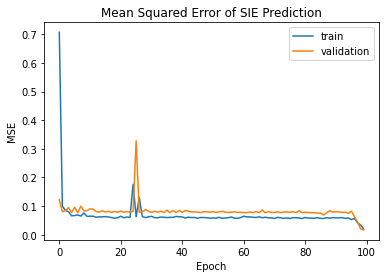

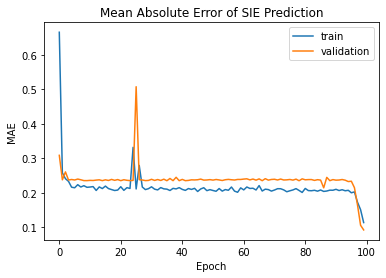

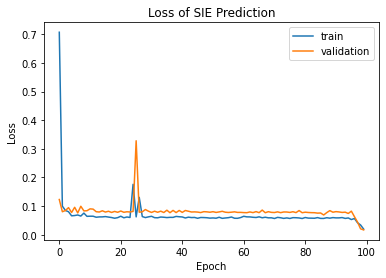

In [11]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Mean Squared Error of SIE Prediction')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mean Absolute Error of SIE Prediction')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss of SIE Prediction')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from numpy import sqrt

#model.load_weights("weights.best.hdf5")

cols = len(df.columns)
pred = model.predict(X_test)

predicted_dataset = dataset
predicted_dataset[len(predicted_dataset)-len(pred):, cols-1] = pred[:, 0]
scaled_predicted_dataset = scaler.inverse_transform(predicted_dataset)

predicted_df = df.copy()
predicted_df['sea_ice_extent'][len(predicted_dataset)-len(pred):] = scaled_predicted_dataset[len(predicted_dataset)-len(pred):, cols-1]

predictions = pd.DataFrame()
predictions['predicted'] = (predicted_df['sea_ice_extent'][len(predicted_dataset)-len(pred):])
predictions['actual'] = (df['sea_ice_extent'][len(predicted_dataset)-len(pred):])
predictions = predictions.astype(float)

4/4 [==============================] - 2s 16ms/step


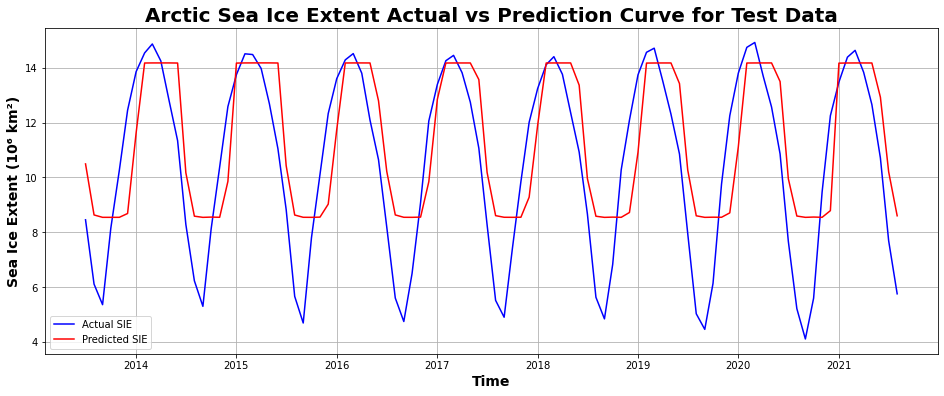

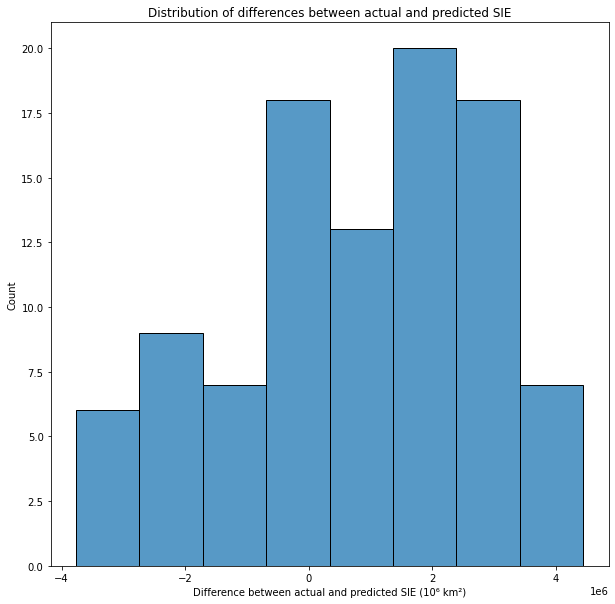

MSE :  4672978913619.898 (10⁶ km²)
MSPE : 10.725 %
RMSE :  2161707.407032667 (10⁶ km²)
RMSPE : 32.75 %
MAE :  1810716.7346938776 (10⁶ km²)
MAPE :  18.324 %
R2 :  26.595


In [13]:
plt.figure(figsize = (16,6))
ax = plt.axes()
# ax.set_facecolor('#dcdcdc')

plt.title('Arctic Sea Ice Extent Actual vs Prediction Curve for Test Data', fontsize = 20,fontweight = "bold")
plt.xlabel('Time' , fontsize = 14,fontweight = "bold")
plt.ylabel('Sea Ice Extent (10\u2076 km\u00b2)', fontsize = 14,fontweight = "bold")
plt.plot(predictions['actual']/10**6, 'blue', label='Actual SIE')
plt.plot(predictions['predicted']/10**6, 'red', label='Predicted SIE')
plt.legend()
plt.grid()
plt.show

predictions['diff'] = predictions['predicted'] - predictions['actual']
plt.figure(figsize=(10,10))
plt.xlabel('Difference between actual and predicted SIE (10\u2076 km\u00b2)')
sns.histplot(predictions['diff'])
plt.title('Distribution of differences between actual and predicted SIE')
plt.show()

mspe = (np.mean(np.square((predictions['actual'].values - predictions['predicted'].values) / predictions['actual'].values))) * 100
rmspe = (np.sqrt(np.mean(np.square((predictions['actual'].values - predictions['predicted'].values) / predictions['actual'].values)))) * 100

print("MSE : ", mean_squared_error(predictions['predicted'].values, predictions['actual'].values), "(10\u2076 km\u00b2)")
print("MSPE :", round(mspe,3), "%")
print("RMSE : ", sqrt(mean_squared_error(predictions['predicted'].values, predictions['actual'].values)), "(10\u2076 km\u00b2)")
print("RMSPE :", round(rmspe,3), "%")
print("MAE : ", mean_absolute_error(predictions['predicted'].values, predictions['actual'].values), "(10\u2076 km\u00b2)")
print("MAPE : ", round(mean_absolute_percentage_error(predictions['predicted'].values, predictions['actual'].values)*100,3), "%")
print("R2 : ", round(r2_score(predictions['predicted'].values, predictions['actual'].values)*100,3))

In [14]:
# while True:pass